# Metodo Monte Carlo

Sotto il nome di *Monte Carlo* ricadono varie tecniche:
* generazione di numeri casuali secondo una distribuzione nota
* calcolo di integrali con l'uso di numeri casuali
* simulazione di processi casuali anche complessi

Cominciamo a vedere le applicazioni più semplici.

## Generazione di numeri casuali secondo una distribuzione voluta

Cominciamo da una distribuzione uniforme. Già abbiamo visto che è possibile passare da una distribuzione nell'ointervallo $[0, 1[$ ad una distribuzione nell'intervallo $[a, b[$ con una trasformazione lineare:

$x = a+ r\,(b-a)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
def plot_rnd(f, xmin, xmax, nbins=100, num = 100000):
    seq = [f() for i in range(num)]
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(seq, nbins, density=True, range=(xmin, xmax))
    plt.show()

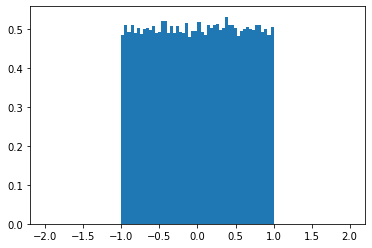

In [3]:
plot_rnd(lambda: -1+random.random()*2, -2, 2)

Per generare una sequenza di numeri interi con distribuzione di probabilità nota si può procedere come segue.
Di seguito un'implementazione, pensata per essere semplice da scrivere in python, ma sicuramente parecchio inefficiente. D'altra parte, una maggiore efficienza può essere ottenuta solo in un linguaggio non interpretato (es.: C, C++).

In [4]:
from scipy.ndimage.interpolation import shift
val=np.array([1,2,3,4,5])
prob=np.array([0.1, 0.3, 0.3, 0.2, 0.1])
# normalize, just in case...
prob=prob/prob.sum()
prob_c=prob.cumsum()
prob_c=shift(prob_c, 1, cval=0)
print(prob_c)
r = 0.5
print(prob_c<r)
print(val[prob_c<r])
print(val[prob_c<r][-1])

[0.  0.1 0.4 0.7 0.9]
[ True  True  True False False]
[1 2 3]
3


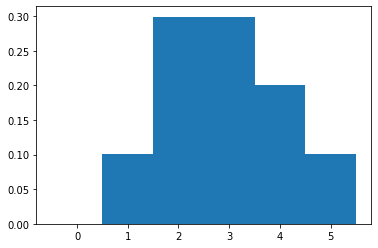

In [5]:
def rnd_discr():
    return val[prob_c<random.random()][-1]
plot_rnd(rnd_discr, -0.5, 5.5, 6)

Più in generale, se è nota una distribuzione, è possibile generare numeri casuali invertendo la sua distribuzione cumulativa. Questo approccio generalizza i due usati sopra.

In particolare, se definiamo:

$\displaystyle F(x) = \int_{-\infty}^xf(x^\prime)\,\mathrm{d}x^\prime$

e poniamo $F(x)=r$, dove $r$ è generato uniformemente in $[0, 1[$, possiamo scrivere:

$\displaystyle \frac{\mathrm{d}P}{\mathrm{d}F} = \frac{\mathrm{d}P}{\mathrm{d}r} 1$

Però possiamo anche scrivere:

$\displaystyle \frac{\mathrm{d}P}{\mathrm{d}x} = \frac{\mathrm{d}P}{\mathrm{d}F} \frac{\mathrm{d}F}{\mathrm{d}x} = \frac{\mathrm{d}P}{\mathrm{d}F} f(x) = f(x)$

Proviamo ad applicarlo per generare secondo una distribuzione esponenziale:
    
$f(x) = \lambda e^{-\lambda x}$

Abbiamo:

$F(x) = 1 -e^{-\lambda x}$

Ponendo $F(x) = r$, invertiamo per ottenere $x$ da $r$:

$\displaystyle x= -\frac{1}{\lambda}\log(1-r)$

In [13]:
def rnd_exp():
    return -math.log(1-random.random())*1.5

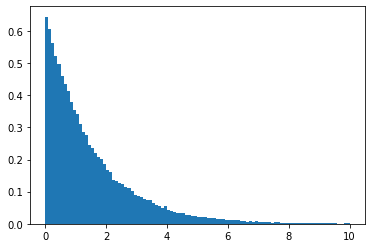

In [14]:
plot_rnd(rnd_exp, 0, 10)

## Distribuzione di punti su una sfera

Si possono generare punti in due dimensioni, $(\theta, \phi)$, tali che i punti siani distribuiti uniformemente su una sfera:

$\displaystyle \frac{\mathrm{d}P}{\mathrm{d}\Omega} = \frac{\mathrm{d}P}{\sin\theta\,\mathrm{d}\theta\,\mathrm{d}\phi}=k$ 

dove $k$ è una costante di normalizzazione.

Possiamo anche riscrivere:

$\displaystyle\frac{\mathrm{d}P}{\sin\theta\,\mathrm{d}\theta\,\mathrm{d}\phi}=f(\theta)\,g(\phi)= k\sin\theta$ 

Dove:

$f(\theta)=c_1\sin\theta$

$g(\phi) = c_2$

e $k=c_1 c_2$.

Usando l'inversione della cumulativa, si ottiene:

$\theta = \mathrm{arccos}(1-r_1)\in ]0, \pi]$

$\phi = 2\pi r_2\in [0, 2\pi[$

dove $r_1$ e $r_2$ sono generati uniformemente in $[0, 1[$.

In [27]:
def rnd_sph():
    return math.acos(1-2*random.random()), 2*math.pi*random.random()

In [35]:
rnd_sph()

(1.7195210873185125, 5.6388980156823765)

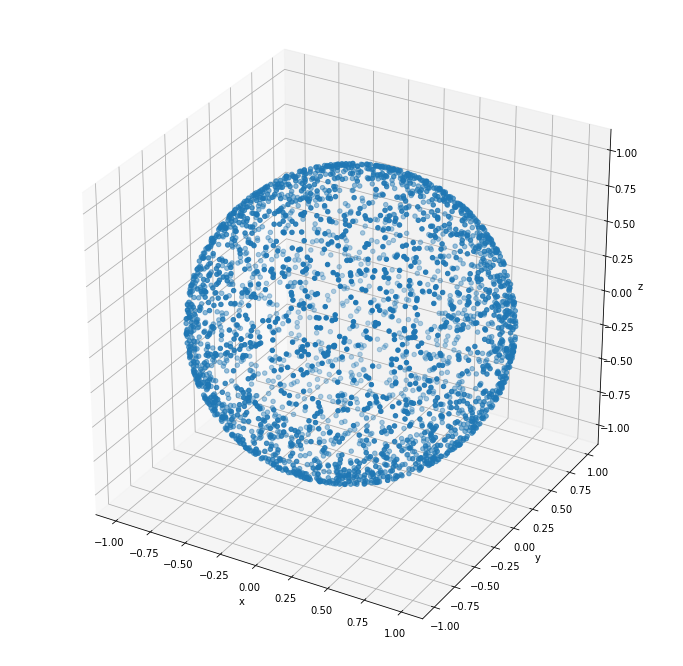

In [46]:
n = 3000
xs = np.empty(n)
ys = np.empty(n)
zs = np.empty(n)
for i in range(n):
    th, ph = rnd_sph()
    st, ct = math.sin(th), math.cos(th)
    sp, cp = math.sin(ph), math.cos(ph)
    xs[i], ys[i], zs[i] = st*cp, st*sp, ct
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.show()

## Distribuzione normale

Per generare una distribuzione gaussiana andrebbe invertita una error function, ma questo numericamente sarebbe inefficiente. 

Esiste una trasformazione che consente di trasformare una coppia di valori distribuiti iniformemente in una coppia di numeri distribuiti secondo una gaussiana, perché in due dimensioni l'integrazione si può fare in modo analitico. Una descrizione si trova <a href="https://www.alanzucconi.com/2015/09/16/how-to-sample-from-a-gaussian-distribution/">qui</a>. La trasformazione prende il nome di Box-Muller.

Esiste anche un algoritmo più efficiente detto <a href="https://heliosphan.org/zigguratalgorithm/zigguratalgorithm.html">Ziqqurat</a>.



## Campionamento Monte Carlo *hit or miss*

Questo metodo è più generale e non richiede inversioni di integrali al costo di essere meno efficiente.

In sostanza, vengono rigettati i punti sotto la curva che si vuole generare.

Usiamo la funzione:

$f(x)=x\,e^{-x}$

Che è normalizzata. Ma la normalizzazione non deve essere necessariamente imposta per applicare il metodo.


In [126]:
def f_mc(x):
    return x*math.exp(-x)
f_mc_v=np.vectorize(f_mc)
xmin, xmax = 0, 10
ymax = 0.4
step=0.01
npts=10000
xs=np.random.rand(npts)*(xmax-xmin)+xmin
ys=np.random.rand(npts)*ymax
hit=ys<f_mc_v(xs)
cols=['red']*npts
for i in range(npts):
    if hit[i]: cols[i]='green'

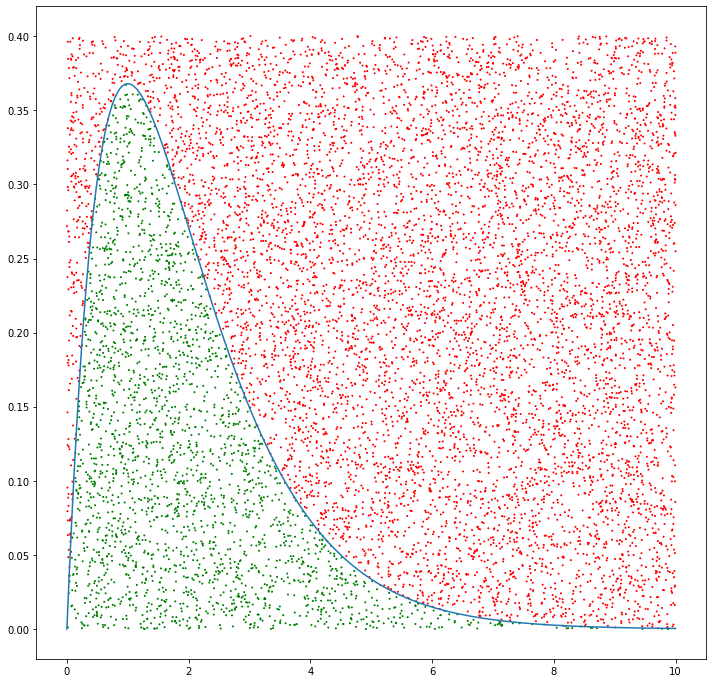

In [127]:
plt.figure(figsize=(12,12))
x=np.arange(xmin, xmax+step, step)
plt.plot(x,f_mc_v(x))
plt.scatter(xs,ys,c=cols,s=1)
plt.show()

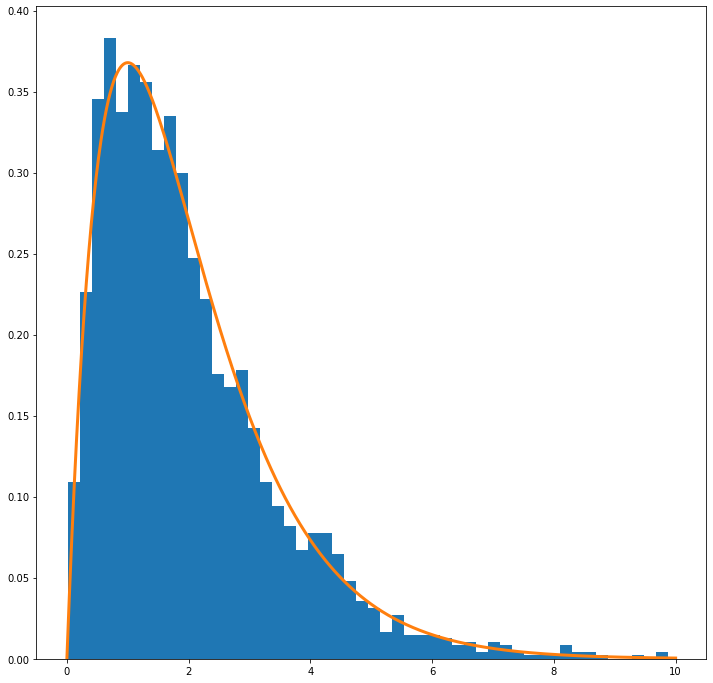

In [134]:
plt.figure(figsize=(12,12))
plt.hist(xs[hit],density=True,bins=50)
plt.plot(x,f_mc_v(x), linewidth=3)
plt.show()

## Calcolo dell'integrale col metodo Monte Carlo

La frazione $f$ del numero di punti *hit* rappresenta la frazione dell'area sotto la curva rispetto all'area del rettangolo consiederato.

In [129]:
a_tot = (xmax-xmin)*ymax
f_hit = len(xs[hit])/npts
a_int = f_hit*a_tot
print(a_tot, f_hit, a_int)

4.0 0.2421 0.9684


L'incertezza può essere approssimativamente stimata dalla deviazione standard di una distribuzione binomiale:

$\displaystyle\sigma_f = \sqrt{\frac{f(1-f)}{N}}$

Va notato che questa incertezza **è indipendente dal numero di dimensioni del problema**. Per il calcolo di integrali a più dimensioni invece il tempo di calcolo più crescere notevolmente con altre tecniche di integrazioni.

In [135]:
sigma_f = math.sqrt(f_hit*(1-f_hit)/npts)
sigma_a = sigma_f*a_tot
print("A = {:.3f} +/- {:.3f}".format(a_int,sigma_a))

A = 0.968 +/- 0.017


# Spunti per esercizi
* generare numeri casuali secondo una distribuzione $f(x)=\sin^2(x)\,e^{-x}$
* calcolare $\pi$ con il metodo Monte Carlo, come area della semicirconferenza sotto la curva $f(x) = \sqrt{x^2+1}$.
* estendere il metodo *hit-or-miss* ad un caso bidimensionale di vostra scelta e calcolare il volume sotto la curva 3D